<a href="https://colab.research.google.com/github/rohts-patil/VQA-Med-2019/blob/master/notebooks/VQA_Plane_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/VQA

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/VQA


In [0]:
import glob
import random

import numpy as np
import pandas as pd

import time
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import LabelEncoder
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
from torch import optim, cuda
from timeit import default_timer as timer

In [0]:
path =r'train/QAPairsByCategory'

filenames = glob.glob(path + "/*.txt")

dfs = []

for filename in filenames:
    df_temp = pd.read_csv(filename,delimiter='|',names=['id','question','answer'])
    df_temp['label'] = df_temp.apply(lambda x: ((filename.split('/')[-1].replace('_train.txt',''))), axis=1)
    dfs.append(df_temp)

df_train = pd.concat(dfs, ignore_index=True)

In [4]:
df_train.head()

,id,question,answer,label
0,synpic41148,what kind of image is this?,cta - ct angiography,C1_Modality
1,synpic43984,is this a t1 weighted image?,no,C1_Modality
2,synpic38930,what type of imaging modality is used to acqui...,us - ultrasound,C1_Modality
3,synpic52143,is this a noncontrast mri?,no,C1_Modality
4,synpic20934,what type of image modality is this?,xr - plain film,C1_Modality


In [0]:
path =r'val/QAPairsByCategory'

filenames = glob.glob(path + "/*.txt")

dfs = []

for filename in filenames:
    df_temp = pd.read_csv(filename,delimiter='|',names=['id','question','answer'])
    df_temp['label'] = df_temp.apply(lambda x: (filename.split('/')[-1].replace('_val.txt','')), axis=1)
    dfs.append(df_temp)

df_valid = pd.concat(dfs, ignore_index=True)

In [6]:
df_valid.head()

,id,question,answer,label
0,synpic54733,what imaging modality was used to take this im...,ct with iv contrast,C1_Modality
1,synpic25647,what kind of scan is this?,xr - plain film,C1_Modality
2,synpic35681,was the mri taken with contrast?,no,C1_Modality
3,synpic39641,"is this a t1 weighted, t2 weighted, or flair i...",t2,C1_Modality
4,synpic35693,is this a noncontrast mri?,yes,C1_Modality


In [7]:
df_train = df_train[df_train['label'] == 'C2_Plane']
df_train.head()

,id,question,answer,label
3200,synpic41148,which plane is this image taken?,axial,C2_Plane
3201,synpic43984,which plane is this image taken?,axial,C2_Plane
3202,synpic38930,what plane is this ultrasound in?,longitudinal,C2_Plane
3203,synpic52143,which plane is the image shown in?,coronal,C2_Plane
3204,synpic20934,in what plane is this x-ray?,lateral,C2_Plane


In [8]:
df_valid = df_valid[df_valid['label'] == 'C2_Plane']
df_valid.head()

,id,question,answer,label
500,synpic54733,in what plane is this image oriented?,axial,C2_Plane
501,synpic25647,what plane is this x-ray in?,ap,C2_Plane
502,synpic35681,what plane is demonstrated?,coronal,C2_Plane
503,synpic39641,in what plane was this image taken?,axial,C2_Plane
504,synpic35693,in what plane is this mri taken?,sagittal,C2_Plane


In [9]:
labelencoder_train = LabelEncoder()
df_train['plane_type'] = labelencoder_train.fit_transform(df_train['answer'])
df_train.head()

,id,question,answer,label,plane_type
3200,synpic41148,which plane is this image taken?,axial,C2_Plane,2
3201,synpic43984,which plane is this image taken?,axial,C2_Plane,2
3202,synpic38930,what plane is this ultrasound in?,longitudinal,C2_Plane,7
3203,synpic52143,which plane is the image shown in?,coronal,C2_Plane,3
3204,synpic20934,in what plane is this x-ray?,lateral,C2_Plane,6


In [10]:
integer_mapping = {l: i for i, l in enumerate(labelencoder_train.classes_)}
integer_mapping

{'3d reconstruction': 0,
 'ap': 1,
 'axial': 2,
 'coronal': 3,
 'decubitus': 4,
 'frontal': 5,
 'lateral': 6,
 'longitudinal': 7,
 'mammo - cc': 8,
 'mammo - mag cc': 9,
 'mammo - mlo': 10,
 'oblique': 11,
 'pa': 12,
 'sagittal': 13,
 'transverse': 14}

In [11]:
labelencoder_valid = LabelEncoder()
df_valid['plane_type'] = labelencoder_valid.fit_transform(df_valid['answer'])
df_valid.head()

,id,question,answer,label,plane_type
500,synpic54733,in what plane is this image oriented?,axial,C2_Plane,2
501,synpic25647,what plane is this x-ray in?,ap,C2_Plane,1
502,synpic35681,what plane is demonstrated?,coronal,C2_Plane,3
503,synpic39641,in what plane was this image taken?,axial,C2_Plane,2
504,synpic35693,in what plane is this mri taken?,sagittal,C2_Plane,13


In [12]:
integer_mapping = {l: i for i, l in enumerate(labelencoder_valid.classes_)}
integer_mapping

{'3d reconstruction': 0,
 'ap': 1,
 'axial': 2,
 'coronal': 3,
 'frontal': 4,
 'lateral': 5,
 'longitudinal': 6,
 'mammo - cc': 7,
 'mammo - mag cc': 8,
 'mammo - mlo': 9,
 'mammo - xcc': 10,
 'oblique': 11,
 'pa': 12,
 'sagittal': 13,
 'transverse': 14}

In [0]:
class PlaneDataSet(Dataset):
    def __init__(self, image_names,plane_types, root_dir, transform=None):
        self.image_names = image_names
        self.plane_types = plane_types
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = '{}.jpg'.format(self.image_names[idx])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.plane_types[idx]
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [0]:
plane_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])


train_ds = PlaneDataSet(df_train['id'].values,df_train['plane_type'].values, r'train/Train_images/', transform=plane_trans)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)

valid_ds = PlaneDataSet(df_valid['id'].values,df_valid['plane_type'].values, r'val/Val_images/', transform=plane_trans)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, num_workers=4)

In [0]:
train_on_gpu = cuda.is_available()
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = torch.nn.Sequential(
            torch.nn.Linear(n_inputs, 256), torch.nn.ReLU(), torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 15), torch.nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = torch.nn.Sequential(
            torch.nn.Linear(n_inputs, 256), torch.nn.ReLU(), torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 15), torch.nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    return model

In [0]:
model = get_pretrained_model('vgg16')

In [0]:
criterion = torch.nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [0]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [19]:
  model, history = train(
    model,
    criterion,
    optimizer,
    train_dl,
    valid_dl,
    save_file_name="plane-vgg.pt",
    max_epochs_stop=30,
    n_epochs=30)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.1050 	Validation Loss: 1.2030
		Training Accuracy: 63.56%	 Validation Accuracy: 63.40%

Epoch: 1 	Training Loss: 0.8190 	Validation Loss: 1.2003
		Training Accuracy: 73.09%	 Validation Accuracy: 66.20%

Epoch: 2 	Training Loss: 0.7549 	Validation Loss: 1.2321
		Training Accuracy: 74.47%	 Validation Accuracy: 67.40%

Epoch: 3 	Training Loss: 0.6854 	Validation Loss: 1.2520
		Training Accuracy: 76.12%	 Validation Accuracy: 66.40%

Epoch: 4 	Training Loss: 0.6454 	Validation Loss: 1.1856
		Training Accuracy: 76.84%	 Validation Accuracy: 68.60%

Epoch: 5 	Training Loss: 0.5859 	Validation Loss: 1.2705
		Training Accuracy: 80.41%	 Validation Accuracy: 67.20%

Epoch: 6 	Training Loss: 0.5602 	Validation Loss: 1.2214
		Training Accuracy: 80.81%	 Validation Accuracy: 66.80%

Epoch: 7 	Training Loss: 0.5124 	Validation Loss: 1.2714
		Training Accuracy: 81.84%	 Validation Accuracy: 69.20%

Epoch: 8 	Training Loss: 0.4891 	Validation Lo

Text(0.5, 1.0, 'Training and Validation Losses')

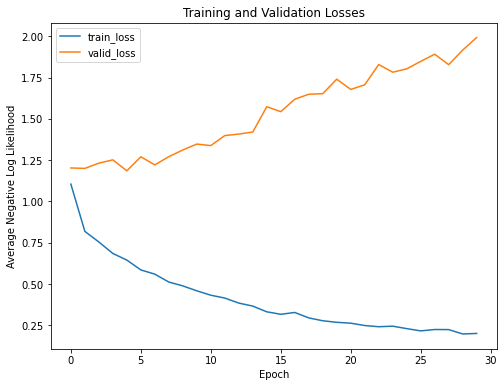

In [20]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

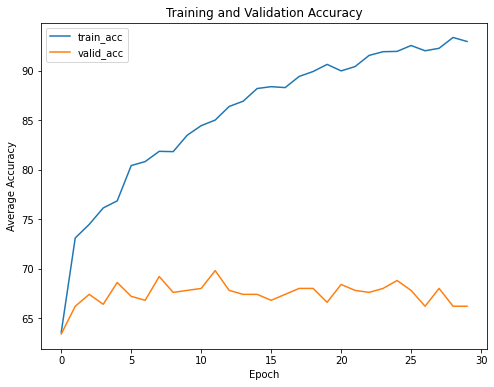

In [21]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [0]:
torch.save(model.state_dict(), 'plane-vgg16.pt')